In [77]:
import torch
import torch.nn as nn
from torch.autograd import grad

import pennylane as qml
from pennylane import numpy as pnp

import numpy as np  

import matplotlib.pyplot as plt  


In [78]:
m = 1.0
mu = 4.0
k = 400.0
lambda1 = 1e-1
lambda2 = 1e-4
lr = 0.002

In [79]:
n_qubits = 3
n_layers = 3


# Generate 200 evenly spaced time values between 0 and 1 using PennyLane NumPy.
# These values represent the training inputs for the PINN/QML model
t_train = pnp.linspace(0, 1, 200)


# Convert the NumPy array to a PyTorch tensor so it can be used as input
# to a PyTorch-based model and participate in the autograd computation graph.
# t_train_torch = torch.tensor(t_train, dtype=torch.float32)
t_train_torch = torch.tensor(t_train, dtype=torch.float32).reshape(-1, 1)

dev = qml.device("default.qubit", wires=n_qubits)

torch.manual_seed(0)
np.random.seed(0)

In [80]:
def ansatz_layer(theta):
    for i in range(n_qubits):
        qml.RZ(theta[i,0], wires=i)
        qml.RX(theta[i,1], wires=i)
        qml.RZ(theta[i,2], wires=i)

    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1) % n_qubits])

def feature_layer(phi):
    for i in range(n_qubits):
        qml.RY(phi[i], wires=i)

@qml.qnode(dev, interface="torch")
def quantum_block(phi, thetas):
    ansatz_layer(thetas[0])
    feature_layer(phi)
    ansatz_layer(thetas[1])
    feature_layer(phi)
    ansatz_layer(thetas[2])

    return qml.expval(qml.PauliZ(0))

In [81]:
class QuantumBranch(nn.Module):

    def __init__(self):
        super().__init__()

        # Ansatz parameter A(theta)
        self.theta = nn.Parameter(
            torch.randn(n_layers, n_qubits, 3) * 0.01
        )

    def forward(self, t):
        if t.dim() == 2:
            t = t.squeeze(-1)

        scale = np.pi

        # Feature map parameter
        phi = torch.stack([scale * t, 2.0 * scale * t, 3.0 * scale * t], dim=1)

        outputs = []
        for i in range(phi.size(0)):
            out = quantum_block(phi[i], self.theta)
            outputs.append(out)

        return torch.stack(outputs).unsqueeze(-1)

In [82]:
class QQ_PINN(nn.Module):

    def __init__(self):
        super().__init__()
        self.branch1 = QuantumBranch()
        self.branch2 = QuantumBranch()

    def forward(self, t):
        return self.branch1(t) + self.branch2(t)

In [83]:
def derivative(u, t):
    return grad(
        outputs=u,
        inputs=t,
        grad_outputs=torch.ones_like(u),
        create_graph=True
    )[0]

def second_derivative(u, t):
    du_dt = derivative(u, t)
    return derivative(du_dt, t)

In [ ]:
def loss_fn(model, t):
    # Create a clean differentiable copy of t.
    # - detach(): remove previous graph history
    # - clone(): avoid in-place side effects
    # - requires_grad_(True): allow autograd to compute du/dt and d2u/dt2
    t = t.clone().detach().requires_grad_(True)

    u = model(t)
    du = derivative(u, t)
    d2u = second_derivative(u, t)

    f = m * d2u + mu * du + k * u

    t0 = torch.zeros((1, 1), dtype=t.dtype, device=t.device)
    t0.requires_grad_(True)
    u0 = model(t0)
    du0 = derivative(u0, t0)

    loss_ic_u  = (u0 - 1.0)**2
    loss_ic_du = du0**2
    loss_f = torch.mean(f**2)

    return loss_ic_u.squeeze(), loss_ic_du.squeeze(), loss_f.squeeze()

Epoch    0 | Loss = 1.1588e+01 | IC_u = 9.9808e-01 | IC_du = 6.2572e-05 | PDE = 1.0589e+05
||u||: 0.9325940954276137 ||u'||: 10.916714668273926 ||u''||: 228.8065185546875


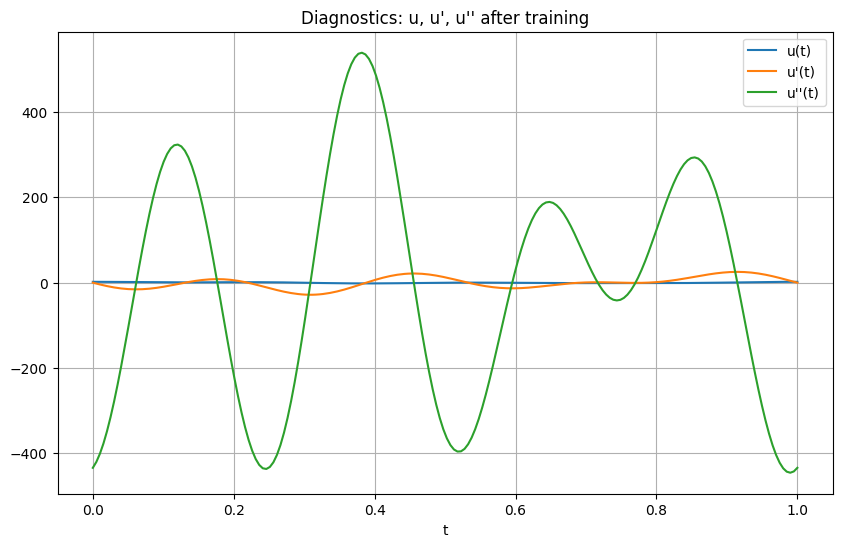

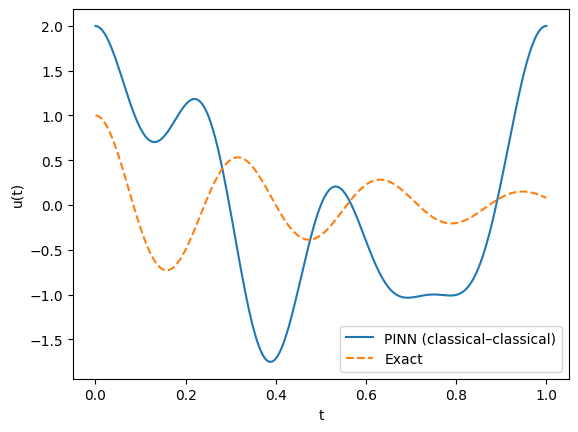

Epoch  100 | Loss = 5.3453e+00 | IC_u = 3.3433e-01 | IC_du = 5.5741e-02 | PDE = 5.0054e+04
||u||: 0.6887772873360208 ||u'||: 9.755189895629883 ||u''||: 205.34246826171875


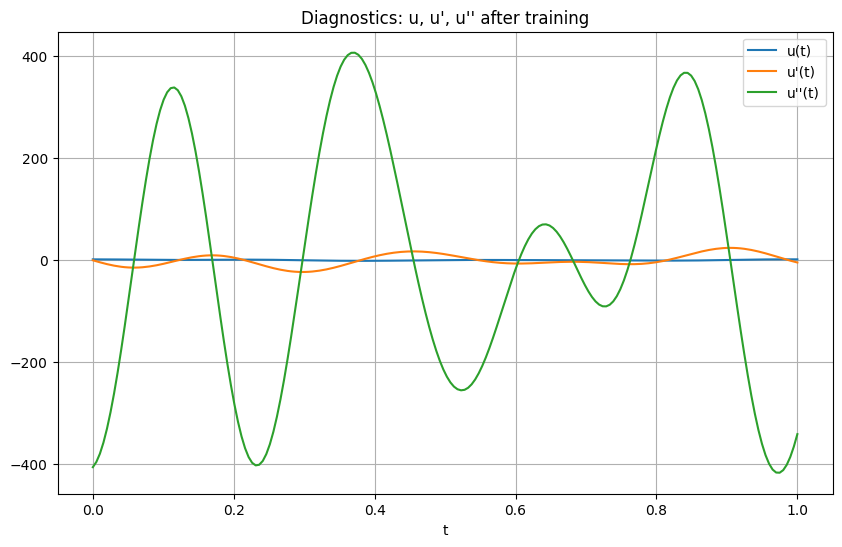

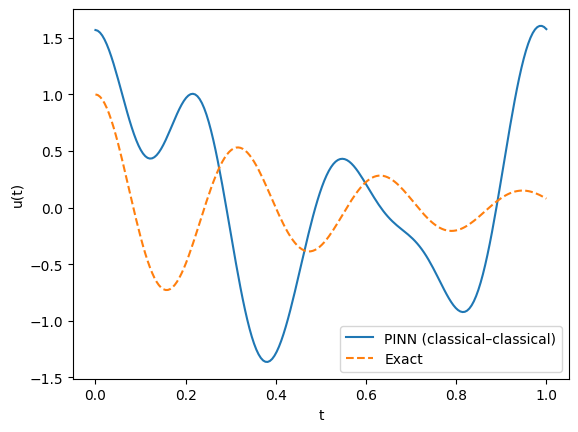

Epoch  200 | Loss = 1.0878e+00 | IC_u = 2.6329e-02 | IC_du = 1.9034e-02 | PDE = 1.0595e+04
||u||: 0.4110052671469538 ||u'||: 7.251095771789551 ||u''||: 156.46279907226562


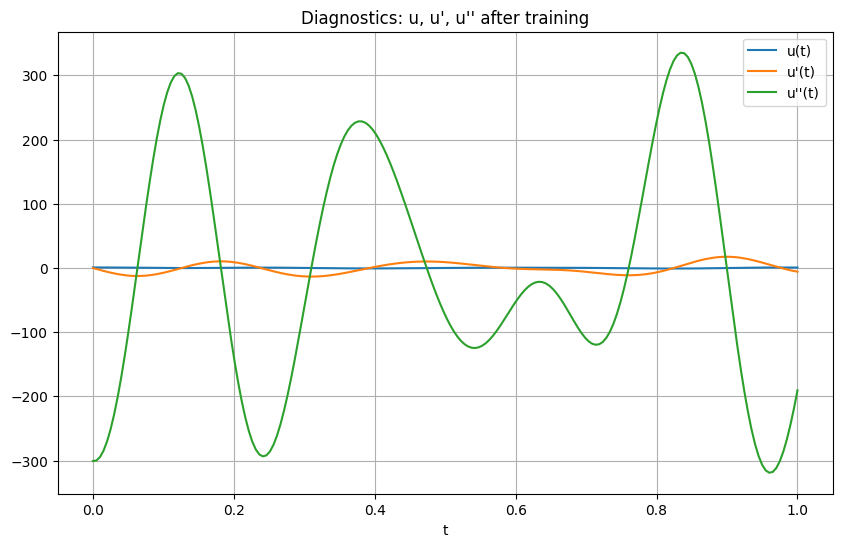

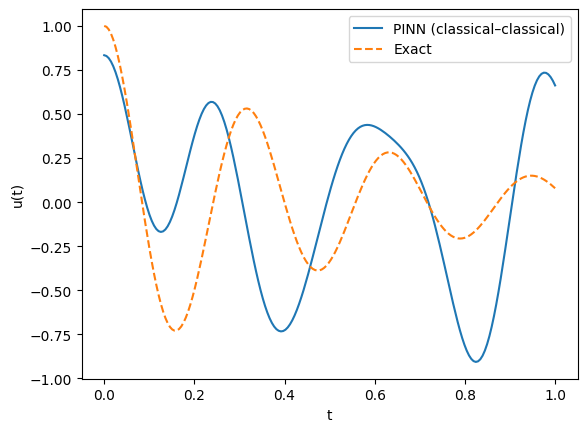

Epoch  300 | Loss = 5.3420e-01 | IC_u = 9.8138e-02 | IC_du = 1.4909e-02 | PDE = 4.3457e+03
||u||: 0.29632327517673873 ||u'||: 5.615005016326904 ||u''||: 125.75048828125


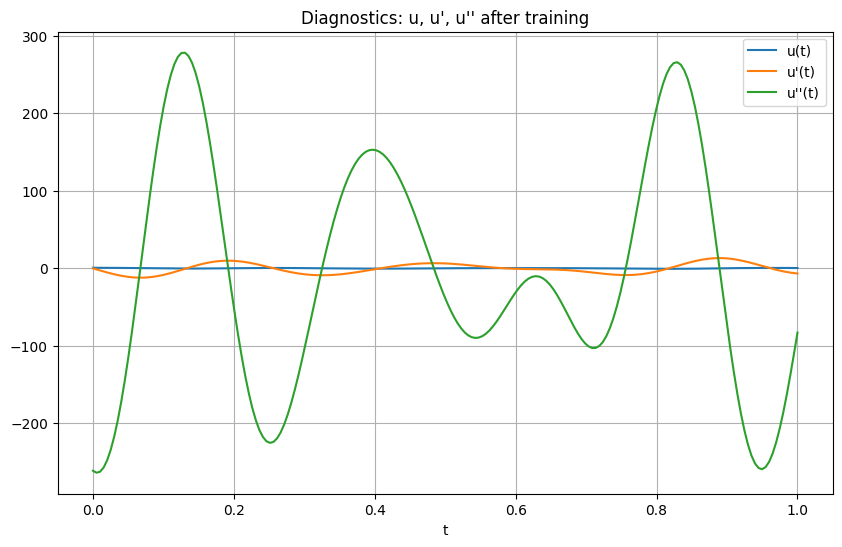

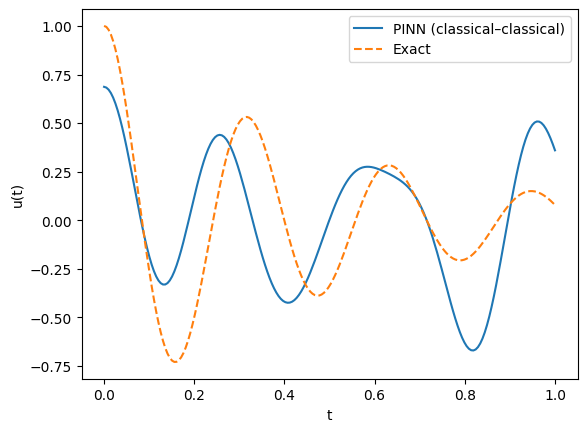

In [ ]:
model = QQ_PINN()
optimizer = torch.optim.Adam(model.parameters(), lr)

# t_train_torch = torch.linspace(0.0, 1.0, 200, dtype=torch.float32).reshape(-1, 1)

n_epochs = 1800

for epoch in range(n_epochs):
    optimizer.zero_grad()

    lic_u, lic_du, lf = loss_fn(model, t_train_torch)


    # Rebuild the total loss with the effective λ2
    loss = lic_u + lambda1 * lic_du + lambda2 * lf

    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"Epoch {epoch:4d} | "
            f"Loss = {loss.item():.4e} | "
            f"IC_u = {lic_u:.4e} | "
            f"IC_du = {lic_du:.4e} | "
            f"PDE = {lf:.4e}"
        )

        t_diag = t_train_torch.clone().detach().requires_grad_(True)

        # compute u, du, d2u with graph
        u_diag  = model(t_diag)
        du_diag = derivative(u_diag, t_diag)
        d2u_diag = second_derivative(u_diag, t_diag)

        print(
            "||u||:", u_diag.abs().mean().item(),
            "||u'||:", du_diag.abs().mean().item(),
            "||u''||:", d2u_diag.abs().mean().item()
        )

        # 2) now you can disable gradients for numpy conversion
        with torch.no_grad():
            u_diag  = u_diag.squeeze().cpu().numpy()
            du_diag = du_diag.squeeze().cpu().numpy()
            d2u_diag = d2u_diag.squeeze().cpu().numpy()
            t_np = t_diag.squeeze().cpu().numpy()

        # plotting
        plt.figure(figsize=(10, 6))
        plt.plot(t_np, u_diag, label="u(t)")
        plt.plot(t_np, du_diag, label="u'(t)")
        plt.plot(t_np, d2u_diag, label="u''(t)")
        plt.legend()
        plt.xlabel("t")
        plt.title("Diagnostics: u, u', u'' after training")
        plt.grid(True)
        plt.show()

        omega = np.sqrt(k - (mu/2)**2)

        def u_exact(t):
            return np.exp(-mu*t/2) * (np.cos(omega*t) + (mu/(2*omega))*np.sin(omega*t))

        t_np = t_train_torch.cpu().numpy().flatten()
        u_pred = model(t_train_torch).detach().cpu().numpy().flatten()
        u_ex = u_exact(t_np)

        plt.plot(t_np, u_pred, label="PINN (classical–classical)")
        plt.plot(t_np, u_ex, '--', label="Exact")
        plt.legend()
        plt.xlabel("t")
        plt.ylabel("u(t)")
        plt.show()